In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
%matplotlib inline
# %matplotlib notebook

In [2]:
cv.__version__

'4.2.0'

In [5]:
img1 = cv.imread('/Users/tejaswin.p/Downloads/herzjesu_dense/urd/0001.png',cv.IMREAD_GRAYSCALE) # queryImage
img2 = cv.imread('/Users/tejaswin.p/Downloads/herzjesu_dense/urd/0002.png',cv.IMREAD_GRAYSCALE) # trainImage

img1 = cv.resize(img1, None, fx=0.2, fy=0.2)
img2 = cv.resize(img2, None, fx=0.2, fy=0.2)

# Initiate ORB detector
orb = cv.ORB_create()
# orb = cv.xfeatures2d.SIFT_create()
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

In [6]:
img1.shape

(410, 614)

In [33]:
# # create BFMatcher object
# bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
# # Match descriptors.
# matches = bf.match(des1,des2)
# # Sort them in the order of their distance.
# matches = sorted(matches, key = lambda x:x.distance)
# # Draw first 10 matches.
# img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:100],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# plt.figure(figsize=(20, 25))
# plt.imshow(img3);


# FLANN_INDEX_KDTREE = 1
# index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
# search_params = dict(checks=50)
# flann = cv.FlannBasedMatcher(index_params,search_params)
brute = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
matches = brute.match(des1,des2)
matches = sorted(matches, key=lambda x:x.distance)[:100]

good = []
pts1 = []
pts2 = []
# ratio test as per Lowe's paper
# for i,(m,n) in enumerate(matches):
#     if m.distance < 0.8*n.distance:
#         good.append(m)
#         pts2.append(kp2[m.trainIdx].pt)
#         pts1.append(kp1[m.queryIdx].pt)

for i, m in enumerate(matches):
    good.append(m)
    pts2.append(kp2[m.trainIdx].pt)
    pts1.append(kp1[m.queryIdx].pt)

In [34]:
print len(matches)
matches[0]

100


<DMatch 0x120cfd6f0>

In [35]:
# pts1 = []
# pts2 = []
# # ratio test as per Lowe's paper
# for i, m in enumerate(matches):
#     pts2.append(kp2[m.trainIdx].pt)
#     pts1.append(kp1[m.queryIdx].pt)

In [36]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1, pts2, cv.LMEDS)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

In [37]:
pts1.shape

(91, 2)

In [38]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

In [39]:
def custom_lines(points, funmat, l2r=True):
    size = points.shape[0]
    hmg = np.hstack([points, np.ones((size, 1))])
    if l2r:
        lines = np.dot(hmg, funmat)
    else:
        lines = np.dot(funmat, hmg.T).T
    return lines

In [40]:
lines1 = custom_lines(pts2[:50], F)
img_left, _ = drawlines(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image

lines2 = custom_lines(pts1[:50], F, l2r=False)
img_right, _ = drawlines(img2,img1,lines2,pts2,pts1)

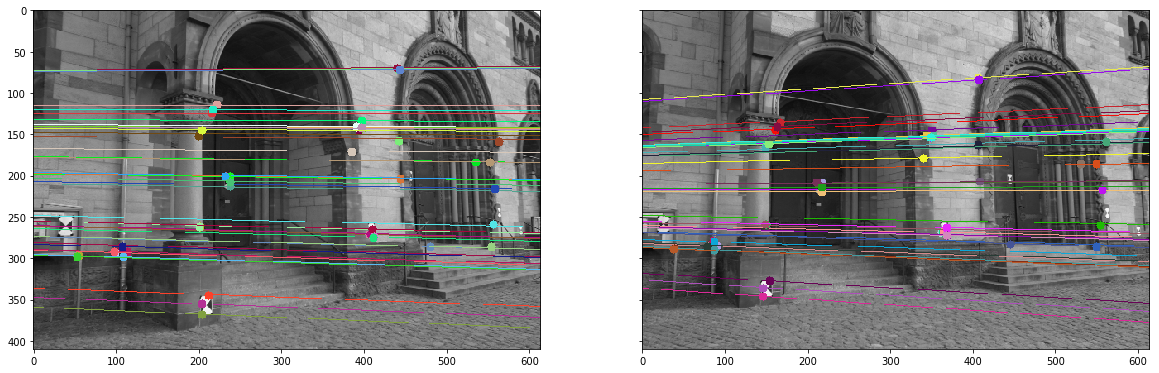

In [41]:
fig, axs = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches((20, 25))
axs[0].imshow(img_left)
axs[1].imshow(img_right)

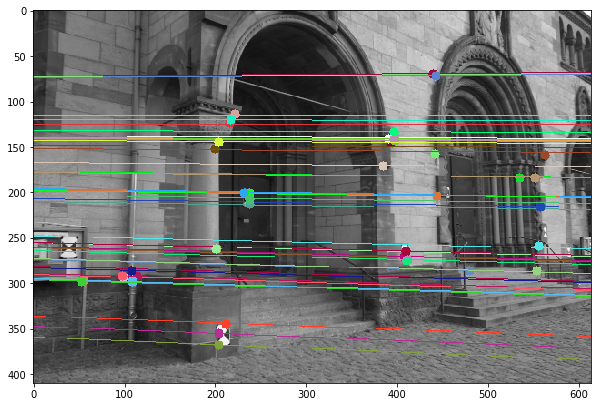

In [42]:
plt.figure(figsize=(10, 15))
plt.imshow(img_left)

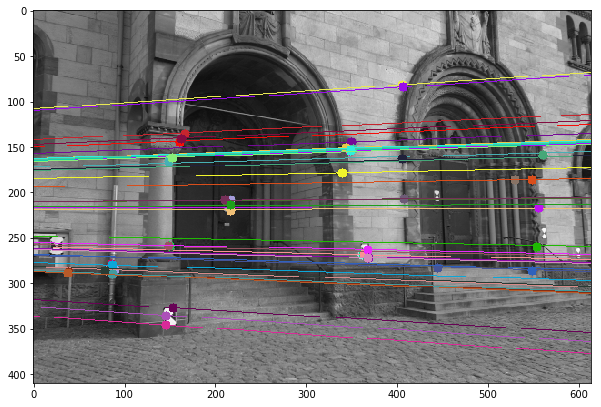

In [43]:
plt.figure(figsize=(10, 15))
plt.imshow(img_right)

### Epipoles computation

In [44]:
def epipole(funmat, left=True):
    # Returns values, vectors
    if left is True:
        w, v = np.linalg.eig(funmat.T.dot(funmat))
    else:
        w, v = np.linalg.eig(funmat.dot(funmat.T))

    pole = v[:, np.argmin(w)]
    pole = pole / pole[-1]
    return pole

In [45]:
pole_left = epipole(F, left=True)
pole_right = epipole(F, left=False)

In [46]:
pole_right

array([-1.71345949e+03,  2.20442134e+02,  1.00000000e+00])

In [47]:
F.shape

(3, 3)

### Triangulation

Pg 19: <https://www.robots.ox.ac.uk/~vgg/hzbook/hzbook1/HZepipolar.pdf>

In [48]:
Prj_left = np.hstack([np.eye(3), np.zeros((3, 1))])
print Prj_left

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


In [49]:
def skew(vector):
    """
    this function returns a numpy array with the skew symmetric cross product matrix for vector.
    the skew symmetric cross product matrix is defined such that
    np.cross(a, b) = np.dot(skew(a), b)

    :param vector: An array like vector to create the skew symmetric cross product matrix for
    :return: A numpy array of the skew symmetric cross product vector
    """

    return np.array([[0, -vector[2], vector[1]], 
                     [vector[2], 0, -vector[0]], 
                     [-vector[1], vector[0], 0]])

In [50]:
def opencv_other_projection(fmat):
    w, v = np.linalg.eig(fmat.dot(fmat.T))
    e = v[:, np.argmin(w)]
    cols_p2 = np.matmul(skew(e), fmat)
    
    P2mat = np.zeros((3, 4))
    for j in range(3):
        for i in range(3):
            P2mat[j, i] = cols_p2[j, i]
            P2mat[j, 3] = e[j]
            
    return P2mat

In [51]:
opencv_Prj_right = opencv_other_projection(F)
opencv_Prj_right

array([[ 6.38344873e-05,  2.26940704e-03,  1.27613645e-01,
        -9.91825342e-01],
       [ 4.96158922e-04,  1.76397095e-02,  9.91824124e-01,
         1.27601554e-01],
       [ 3.47670250e-06,  1.82726492e-06,  2.09855812e-02,
         5.78843763e-04]])

In [388]:
print pole_right
print skew(pole_right)

[-825.26178472  192.42282761    1.        ]
[[   0.           -1.          192.42282761]
 [   1.            0.          825.26178472]
 [-192.42282761 -825.26178472    0.        ]]


In [349]:
Prj_right = np.hstack([np.dot(skew(pole_right), F), 
                       np.expand_dims(pole_right, -1)])
print Prj_right

[[ 3.60761062e-01  2.66710806e+00  1.92441297e+02 -8.25261785e+02]
 [ 1.54718005e+00  1.14387035e+01  8.25258690e+02  1.92422828e+02]
 [ 9.55918071e-03 -5.31607595e-03  1.58373727e+01  1.00000000e+00]]


### Using OpenCV ...


In [83]:
_samples = sorted(np.random.randint(0, pts1.shape[0], 10))
_samples

[4, 22, 31, 32, 34, 40, 45, 53, 56, 84]

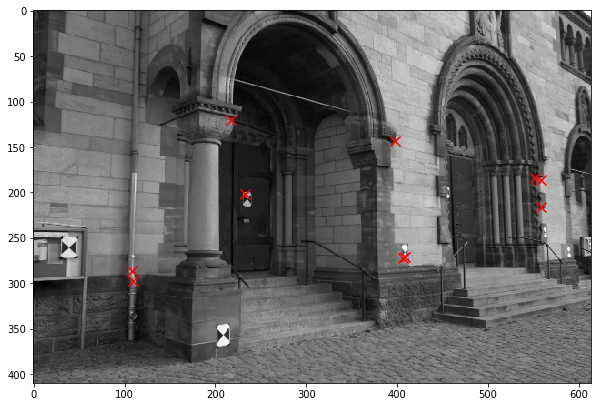

In [84]:
plt.figure(figsize=(10, 15))
plt.imshow(img1, cmap='gray')
plt.scatter([_[0] for _ in pts1[_samples]], [_[1] for _ in pts1[_samples]], marker='x', color='red', s=100);

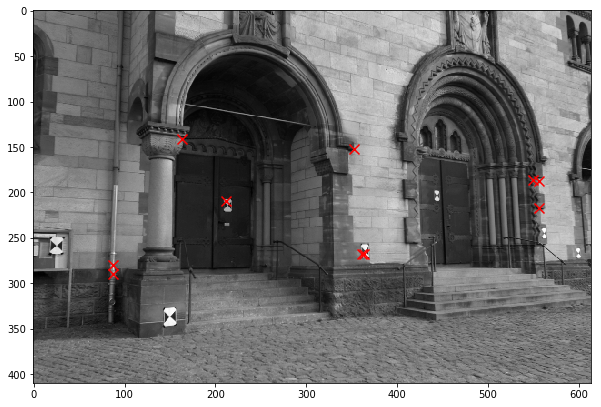

In [86]:
plt.figure(figsize=(10, 15))
plt.imshow(img2, cmap='gray')
plt.scatter([_[0] for _ in pts2[_samples]], [_[1] for _ in pts2[_samples]], marker='x', color='red', s=100);

$$
\begin{bmatrix}
x \\ y \\ 1
\end{bmatrix} = \alpha
\begin{bmatrix}
p_1 & p_2 & p_3 & p_4 \\
p_5 & p_6 & p_7 & p_8 \\
p_9 & p_{10} & p_{11} & p_{12}
\end{bmatrix}
\begin{bmatrix}
X \\ Y \\ Z \\ 1
\end{bmatrix}
$$

$$
\begin{bmatrix}
x \\ y \\ 1
\end{bmatrix} = \alpha
\begin{bmatrix}
p_1^T.X \\
p_5^T.X \\
p_9^T.X
\end{bmatrix}
$$

$$
0 = 
\begin{bmatrix}
0 & -1 & y \\
1 & 0 & -x \\
-y & x & 0
\end{bmatrix}
\begin{bmatrix}
p_1^T.X \\
p_5^T.X \\
p_9^T.X
\end{bmatrix}
$$

$$
0 = 
\begin{bmatrix}
yp_9^T.X - p_5^T.X \\
p_1^T.X -xp_5^T.X \\
xp_5^T.X - yp_1^T.X
\end{bmatrix}
$$

Rank == 2; last row is linear combination of first two. 3 unknowns (X, Y, Z) and two equations.

==> Requires 2nd view of the same points!

$$
\begin{bmatrix}
0 \\ 0 \\ 0 \\ 0
\end{bmatrix} = 
\begin{bmatrix}
yp_9^T.X - p_5^T.X \\
p_1^T.X -xp_5^T.X \\
kq_9^T.X - q_5^T.X \\
q_1^T.X -jq_5^T.X \\
\end{bmatrix}
$$

$$
0 = 
\begin{bmatrix}
yp_9^T - p_5^T \\
p_1^T -xp_5^T \\
kq_9^T - q_5^T \\
q_1^T -jq_5^T \\
\end{bmatrix} X
$$

In [87]:
def triangulate(points_array, pmats_array):
    assert len(points_array) == len(pmats_array) == 2
    assert pmats_array[0].shape == (3, 4)
    
    num_points = points_array[0].shape[0]
    print num_points
    
    A = np.zeros((2*2*num_points, 4))
    print A.shape
    
    row = 0
    for n in range(num_points):
        for i in range(2):
            # print n, i, (row, row+1)
            x, y = points_array[i][n]
            p1, p5, p9 = pmats_array[i]
            
            A[row] = y*p9 - p5
            A[row+1] = p1 - x*p9
            
            row += 2
            
    assert row == A.shape[0]
    
    u, s, vh = np.linalg.svd(A.T)
    hmg = vh[np.argmin(s)]
    
    raw = np.zeros((num_points, 3))
    i = 0
    for n in range(num_points):
        extra = hmg[i+3]
        raw[n] = np.array([hmg[i], hmg[i+1], hmg[i+2]]) / extra
        i += 4
        
    assert hmg.shape[0] == i
    return raw

In [88]:
from scipy import linalg as splg
from mpl_toolkits.mplot3d import Axes3D

def pose(pmat):
    # Position
    M = pmat[:, :3]
    assert M.shape == (3, 3)
    
    last = pmat[:, -1]
    C = -1.0 * np.linalg.inv(M).dot(last)
    
    K, R = splg.rq(M)
    return C, R, K

In [89]:
opencv_Prj_right

array([[ 6.38344873e-05,  2.26940704e-03,  1.27613645e-01,
        -9.91825342e-01],
       [ 4.96158922e-04,  1.76397095e-02,  9.91824124e-01,
         1.27601554e-01],
       [ 3.47670250e-06,  1.82726492e-06,  2.09855812e-02,
         5.78843763e-04]])

In [90]:
rw_points = triangulate([pts1, pts2], [Prj_left, opencv_Prj_right])

91
(364, 4)


In [91]:
rw_points[_samples]

array([[-1.51712522e+01,  5.74327726e+01, -2.47234032e-01],
       [-3.47711151e+02,  2.06717283e+01, -6.10042633e+00],
       [ 7.21490729e+00,  5.51101372e+01,  1.15864542e-01],
       [ 8.65620351e+00,  4.26408259e+01,  1.61840708e-01],
       [ 9.44762269e+00,  5.49240776e+01,  1.51495888e-01],
       [ 1.82045075e+01,  4.25590938e+01,  3.39029552e-01],
       [-3.24615079e+01,  4.77640626e+01, -5.20310268e-01],
       [ 1.86658409e+02, -3.77116109e+01,  3.08453489e+00],
       [ 1.69734502e+01,  4.26408259e+01,  3.21120137e-01],
       [ 2.78136629e+02, -2.02492644e+01,  4.41071445e+00]])

In [92]:
def decompose(P):
    assert P.shape == (3, 4)
    M = P[:, :3]
    K = np.linalg.cholesky(M.dot(M.T))
    K = K / K[2, 2]
    
    full = np.dot(np.linalg.inv(K), P)
    
    A = full[:, :3]
    lbd = np.cbrt(1.0 / np.linalg.det(A))
    
    matrix = lbd * full
    R = matrix[:, :3]
    t = matrix[:, -1].dot(-R.T)
    return K, R, t

In [93]:
K_left, R_left, t_left = decompose(Prj_left)

In [94]:
K_right = np.array([
[3.122903949917254e-14, 0.1076309898093855, 6.08102522831827],
[0, 0.8365975129632442, 47.26224629836977],
[2.036842959613577e-20, 9.707396085747113e-21, 1]
])

In [95]:
R_right = np.array([
[-0.9998213388556849, 0.01890141461006153, 0.0001639956226943844],
[0.01890139999952535, 0.9998213485138913, -9.018825845235e-05],
[0.000165671010298642, 8.707239845217334e-05, 0.9999999824857567]
])

In [96]:
t_right = np.array([-1.53846e+15, 5.70803, 0.0276143])

In [97]:
R_left

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [98]:
def draw_lines(points, center, ax):
    combined = points.tolist()
    combined.append(center.tolist())
    # for p1, p2 in combinations(combined, 2):
    colors = ['red', 'green', 'blue']
    for i ,p1 in enumerate(points):
        p2 = center
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], c=colors[i])

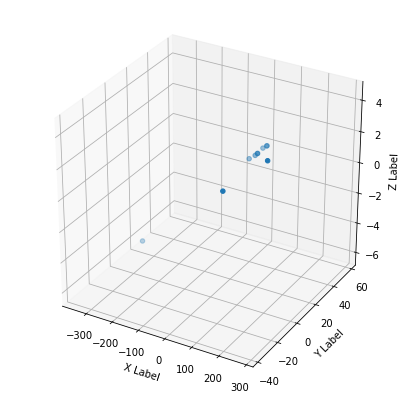

In [123]:
from mpl_toolkits.mplot3d import axes3d, Axes3D

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

frame_left = np.array([(500, 0, 0), (0, 10, 0), (0, 0, 1)])
frame_right = R_right.dot(frame_left.T).T + t_right

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.scatter(rw_points[_samples, 0], rw_points[_samples, 1], rw_points[_samples, 2])
# ax.text(rw_points[_samples, 0], rw_points[_samples, 1], rw_points[_samples, 2], map(str, _samples))

# draw_lines(frame_left, t_left, ax);
# draw_lines(frame_right, t_right, ax);

In [109]:
map(str, _samples)

['4', '22', '31', '32', '34', '40', '45', '53', '56', '84']

In [124]:
from pymvg.plot_utils import plot_camera

In [125]:
from pyquaternion import Quaternion

In [132]:
left_q = Quaternion(matrix=R_left)
right_q = Quaternion(matrix=-R_right)

In [131]:
np.linalg.det(-R_right)

1.0

In [368]:
left_q, right_q

(Quaternion(1.0, 0.0, 0.0, 0.0),
 Quaternion(0.0001541945863691056, 0.9990031717831427, -0.044637915732297015, -0.0003089827284280417))

In [133]:
from pymvg.multi_camera_system import CameraModel
from pymvg.plot_utils import plot_camera

In [134]:
Prj_left

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])

In [383]:
left_k

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [138]:
left_cam = CameraModel(name='left', width=400, height=400, 
                       _rquat=np.array(list(left_q)), _camcenter=t_left,
                       P=Prj_left, K=K_left, 
                       distortion=np.zeros(5), rect=None)

In [143]:
right_cam = CameraModel(name='right', width=400, height=400, 
                       _rquat=np.array(list(right_q)), _camcenter=t_right,
                       P=opencv_Prj_right, K=K_right, 
                       distortion=np.zeros(5), rect=None)

ValueError: matrix P must have element (2,2) near 1.0

array([-1.53846e+15,  5.70803e+00,  2.76143e-02])

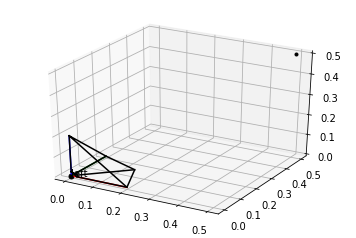

In [139]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot_camera(ax, left_cam)

# put some points to force mpl's view dimensions
force = np.array([[0,0,0], [0.5, 0.5, 0.5]])
ax.plot( force[:,0], force[:,1], force[:,2], 'k.')

# _x, _y, _z = subset_points(rw_points, 10, 15)
# ax.scatter(
#     _x, _y, _z,
#     label='POINTS'
# )

In [178]:
Prj_left

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])

In [163]:
list(left_q)

[1.0, 0.0, 0.0, 0.0]

In [157]:
img_left.shape

(459, 612, 3)